## Explorations with multiple signals

In [1]:
# Import packages that you may already have pip installed in your environment.

import sys
import scipy

import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings

# Import other packages which are less common and specific to the task at hand.

import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12645)

###  Functions and utils

In [2]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = 10**6 * pc

Power Spectral Density **with** noise confusion from galactic binaries, as fitted after one year of observation time in https://arxiv.org/pdf/1803.01944.pdf.

In [3]:
def PowerSpectralDensity(f):
    """
    Power Spectral Density for the LISA detector assuming it has been active for a year. 
    I found an analytic version in one of Niel Cornish's paper which he submitted to the arXiv in
    2018. I evaluate the PSD at the frequency bins found in the signal FFT.
    
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf.
    Values chosen for confusion noise after 1 year of observation.
    [16/12/2020]: removed confusion noise after 1 year of observation. Avoid confusion
                  between different timescales of the problem.
    
    """
    
    sky_averaging_constant = 1.0 # set to one for one source
    #(20/3) # Sky Averaged <--- I got this from Jonathan's notes
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**(-3)    

    Poms = ((1.5e-11)*(1.5e-11))*(1 + np.power((2e-3)/f, 4))  # Optical Metrology Sensor
    Pacc = (3e-15)*(3e-15)* (1 + (4e-4/f)*(4e-4/f))*(1 + np.power(f/(8e-3),4 ))  # Acceleration Noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    Sc = 9e-45 * np.power(f,-7/3)*np.exp(-np.power(f,alpha) + beta*f*np.sin(k*f)) * (1 + np.tanh(gamma*(f_k- f)))  

    PSD = (sky_averaging_constant)* ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD

    return PSD

In [4]:
def inner_prod_FD(sig1_f,sig2_f,PSD,delta_f):
    """
    Only makes sense for continuous fourier transforms. (No dt's floating around). 
    This takes as input dimensionful quantities.
    
    This is the continous Fourier transform inner product.
    """
    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

Here we define the TaylorF2 approximant up to 3.5PN contributions.
References for TaylorF2 models

- https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)]
- https://arxiv.org/pdf/0907.0700.pdf [Eqs.(3.17)-(3.18)]

In [5]:
def htilde(f,Deff,params,tc,phic,tune):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Important:
    
    This model is defined in the frequency domain directly and it necessitates
    continuous fourier transforms in the inner products (no discretizations!)
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    # Units
    
    GM_sun = 1.3271244*1e20
    c =2.9979246*1e8
    M_sun =1.9884099*1e30
    G = 6.6743*1e-11
    pc= 3.0856776*1e16
    pi = np.pi
    Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp_true = np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    
    # PN expansion parameter (velocity).
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    psi_const = 2*pi*f*tc - 2*phic - pi/4
    psi1PN = (3715/756+55/9*eta_true)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta_true*v**(-2)
    psi2PN = (15293365/508032+27145/504*eta_true+3085/72*eta_true**2)*v**(-1)
    psi25PNlog = pi*(38645/252- 65/3 *eta_true)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 -640/3 * pi**2 -6848/21 *np.euler_gamma
              + eta_true*(-15335597827/3048192+2255/12 * pi**2-1760/3 * theta - 12320/9 * delta)
              + eta_true**2 *76055/1728 - eta_true**3 * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + 378515./1512 *eta_true - 74045./756 * eta_true**2* tune)

    psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    
    return amplitude* np.exp(-1j*psi)

Add in function to gauge time to chirp (used to get total observation time for each binary)

In [6]:
def T_chirp(fmin,M_chirp,eta):
    
    """
    Function to give time at chirp from an initial frequency. 
    Used to pick out the total observation time. 
    """
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

### Generate resolvable signals and discretize signal

Input some true parameters for the true signal and for the unresolved binaries. We choose these to resemble a gravitational wave passing by.

In [7]:
# minimum frequency

fmin =  0.0005

In [8]:
"""
Reference signal parameters
"""

# Find a resonable distance for the signal 

Deff = 10**4 *Mpc
logDeff = np.log(Deff)

beta_true = 5.0
eta_true = 0.2
mtot = 2*1e6 #in solar masses
Mchirp = mtot*(eta_true)**(3/5)
Mchirp_true =Mchirp* M_sun
logMchirp_true = np.log(Mchirp_true)

pars = [logMchirp_true,eta_true,beta_true] # array of parameters to sample through

# Fix these two impostors, assume they are known perfectly.
tref =T_chirp(fmin,Mchirp_true,eta_true)
phiref =0.

"""
Overlapping signal #1 
"""

# Find a resonable distance for the signal 

Deff_ov1 = 3*10**3 *Mpc
logDeff_ov1 = np.log(Deff_ov1)

beta_ov1 = 1.0
eta_ov1 = 0.23
mtot_ov1 = 1*1e6 #in solar masses
Mchirp_ov1 = mtot_ov1*(eta_ov1)**(3/5)
Mchirp_ov1 =Mchirp_ov1* M_sun
logMchirp_ov1 = np.log(Mchirp_ov1)

pars_ov1 = [logMchirp_ov1,eta_ov1,beta_ov1] # array of parameters to sample through

# Fix these two impostors, assume they are known perfectly.

tov1 =T_chirp(fmin,Mchirp_ov1,eta_ov1)
phiov1 =np.pi

"""
Overlapping signal #2 
"""

# Find a resonable distance for the signal 

Deff_ov2 = 2*10**3 *Mpc
logDeff_ov2 = np.log(Deff_ov2)

beta_ov2 = 2.4
eta_ov2 = 0.08
mtot_ov2 = 4*1e6 #in solar masses
Mchirp_ov2 = mtot_ov2*(eta_ov2)**(3/5)
Mchirp_ov2 =Mchirp_ov2* M_sun
logMchirp_ov2 = np.log(Mchirp_ov2)

pars_ov2 = [logMchirp_ov2,eta_ov2,beta_ov2] # array of parameters to sample through

# Fix these two impostors, assume they are known perfectly.

tov2 =T_chirp(fmin,Mchirp_ov2,eta_ov2)
phiov2 =.3*np.pi

Here we set up the signal in the time and frequency domain.
Notice that the discretization of the signal depends on the chosen masses of the system in the first place!

In [9]:
"""
Discretization of the signal.
"""

fmax =  c**3/(6*np.sqrt(6)*pi*G*Mchirp_true *eta_true**(-3/5))
t_year = 365*24*60*60       

# Take signal in seconds. 
# Pick lowest observation time among all sources. 

T_obs = min(T_chirp(fmin,Mchirp_true,eta_true),
            T_chirp(fmin,Mchirp_ov1,eta_ov1),
             T_chirp(fmin,Mchirp_ov2,eta_ov2)
            )

delta_t = 1/(2*fmax)
t = np.arange(0,T_obs,delta_t)
N_t = int(2**np.ceil(np.log2(len(t))))  # Length of time domain padded signals

delta_f = 1/T_obs
freq = np.arange(fmin,fmax,delta_f)

print('df:', delta_f)
print('We observe for',
      np.round(T_obs,1),'s, ',
      np.round(12*30*T_obs/t_year,1),'days, ',
      np.round(T_obs/t_year,4),'yr')
print('fmin:', fmin)
print('fmax (chirp):', fmax)
print('Length of frequency array:', len(freq))

df: 4.399587919016278e-05
We observe for 22729.4 s,  0.3 days,  0.0007 yr
fmin: 0.0005
fmax (chirp): 0.0021985873919213874
Length of frequency array: 39


### Build the data array

Next, we build up noise. We use Parseval's theorem to calculate the noise. This amounts to using the following variance

$$
\sigma^2_n= \frac{S_n}{4 dt} N_t
$$

where:

- $\sigma^2$ is the noise variance.
- $S_n$ is the detector's PSD.
- $dt$ is the sampling interval.
- $N_t$ is the length of the (padded) signal.

In [10]:
np.random.seed(12345)
PSD = PowerSpectralDensity(freq)

noisevar = PSD/(4*delta_f) # Noise variance defined for continuous FTs.
noisemean = 0. 

noise_real = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute real noise.
noise_imag = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute imaginary noise.

n_f = np.array(noise_real + 1j*noise_imag)         # noise array in the frequency domain.

Finally, set up the data in the frequency domain. Add noise, extra signals etc. as you please, here. I warn against it.

In [11]:
# resolved signals:
"""
Input your best available waveform in the data.
"""

tune_true = 1.0 # parameter giving h_GR
tune_app = 0.7 # parameter defining h_AP


# Resolved signals, no errors
h_true_vec_f = htilde(freq,Deff,pars,tref,phiref,tune_true)

"""
If you want to treat residuals as missed signals change tune_true
to tune_app below in ov1 and ov2. This implies we are fitting 
the signals out perfectly.
"""
# Overlapping signals
h_ov1_f = htilde(freq,Deff_ov1,pars_ov1,tov1,phiov1,tune_true) 
h_ov2_f = htilde(freq,Deff_ov2,pars_ov2,tov2,phiov2,tune_true)

# Confusion noise from residuals

deltaref =(htilde(freq,Deff,pars,tref,phiref,tune_true) 
           - htilde(freq,Deff,pars,tref,phiref,tune_app))
deltah1 = (htilde(freq,Deff_ov1,pars_ov1,tov1,phiov1,tune_true) 
           - htilde(freq,Deff_ov1,pars_ov1,tov1,phiov1,tune_app))
deltah2 = (htilde(freq,Deff_ov2,pars_ov2,tov2,phiov2,tune_true) 
           - htilde(freq,Deff_ov2,pars_ov2,tov2,phiov2,tune_app))

deltah = deltah1 + deltah2 #+ deltaref 

# data array

"""
If you want to consider residuals as missed signals, add in the
residuals below as confusion noise. It only works of course
if we have simultaneously made the change aboce!
"""
data_f_vec = (h_true_vec_f 
              + h_ov1_f 
              + h_ov2_f 
              #+ deltah # residuals as confusion noise
             )

In [12]:
# Overlaps

def Overlap(sig1_f,sig2_f,PSD,delta_f):
    numerator = inner_prod_FD(sig1_f,sig2_f,PSD,delta_f)
    denominator = np.sqrt(inner_prod_FD(sig1_f,sig1_f,PSD,delta_f) \
                          * inner_prod_FD(sig2_f,sig2_f,PSD,delta_f))
    return numerator/denominator

print('Overlap ref and #1:',Overlap(h_true_vec_f,h_ov1_f,PSD,delta_f))
print('Overlap ref and #2:',Overlap(h_true_vec_f,h_ov2_f,PSD,delta_f))

Overlap ref and #1: 0.18455620242610365
Overlap ref and #2: -0.02851514778212562


And finally we calculate the SNRs, to check that both resolved and sum of the unresolved signals are high enough. If this is not true, then the MCMC will not sample properly, and the Fisher matrix formalism will not work.


If we have chosen realistic numbers for the foreground, we should see the foreground completely dominates detector noise, with very different SNRs. 

We keep detector noise in the analysis, as we want to show it will not have an impact.

In [13]:
# SNR of the resolved source

h_SNR2 = inner_prod_FD(deltah,deltah,PSD,delta_f)  #CTFT
h_ov_1 = inner_prod_FD(h_ov1_f, h_ov1_f,PSD,delta_f)
h_ov_2 = inner_prod_FD(h_ov2_f, h_ov2_f,PSD,delta_f)
#h_ov_3 = inner_prod_FD(h_ov3_f, h_ov3_f,PSD,delta_f)

print('Optimal SNR for the resolved source is',np.sqrt(h_SNR2))
print('Optimal SNR for the overlapping source(s)',np.sqrt(h_ov_1),
      np.sqrt(h_ov_2)#np.sqrt(h_ov_3)
     )

Optimal SNR for the resolved source is 81.33306278417712
Optimal SNR for the overlapping source(s) 789.3139045212895 2216.8624507878


In [14]:
# SNR of the residuals

dh_ov1 = htilde(freq,Deff_ov1,pars_ov1,tov1,phiov1,tune_true) - htilde(freq,Deff_ov1,pars_ov1,tov1,phiov1,tune_app) 
dh_ov2 = htilde(freq,Deff_ov2,pars_ov2,tov2,phiov2,tune_true) - htilde(freq,Deff_ov2,pars_ov2,tov2,phiov2,tune_app)
#dh_ov3 = htilde(freq,Deff_ov3,pars_ov3,tov3,phiov3,tune_true) - htilde(freq,Deff_ov3,pars_ov3,tov3,phiov3,tune_app)
dh_ov_list = [dh_ov1,dh_ov2]#,dh_ov3]

dh_SNRov = [np.sqrt(inner_prod_FD(i,i,PSD,delta_f)) for i in dh_ov_list]

print('Optimal SNR for the overlapping source(s)',dh_SNRov)

Optimal SNR for the overlapping source(s) [30.978512897049242, 76.2593147271557]


### Setting up the MCMC

Here we setup the MCMC check. First of all we write down the priors.

In [15]:
# Priors on frequency
eta_low_range = 0.01  
eta_high_range = 0.25

# Priors on the phase
logMchirp_low_range = np.log(10*M_sun)
logMchirp_high_range = np.log(20000000*M_sun)

# Priors on spin parameters: check Berti, Buonanno, Will.
beta_low = 0.1
beta_high = 9.4

In [16]:
"""
These functions were originally coded up by Ollie Burke.
They must be changed based on the parameters to sample through and their priors.
"""

def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range. Eta is the problem')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range. M is the problem')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

def lprior_beta(beta):

    
    if beta < beta_low or beta > beta_high: # are you out of your range?
        print('I am out of my range. Beta is the problem')
        return -1e10
    else:
        return np.log(1/(beta_high - beta_low))

Next we calculate the (log-)likelihood.
$$
p(d|\theta)\sim \exp\left\{\frac{1}{2}\left(d-h|d-h\right)\right\}
$$
and the log posterior.

In [17]:
"""
These functions were originally coded up by Ollie Burke.
They must be changed based on the parameters to sample through and their priors.
"""

def llike(params, data_f):
    """
    Assumption: Known PSD otherwise need additional term.
    Search the posterior with your approximate waveform.
    """
    
    logMchirp1 = params[0]
    eta1 = params[1]
    beta1 = params[2]
    
    logMchirp2 = params[3]
    eta2 = params[4]
    beta2 = params[5]
    
    logMchirp3 = params[6]
    eta3 = params[7]
    beta3 = params[8]

    signal_f = (  htilde(freq,Deff,    [logMchirp1,eta1,beta1],tref,phiref,tune_true)
                + htilde(freq,Deff_ov1,[logMchirp2,eta2,beta2],tov1,phiov1,tune_app)
                 + htilde(freq,Deff_ov2,[logMchirp3,eta3,beta3],tov2,phiov2,tune_app)
                 #+ htilde(freq,Deff_ov3,[logMchirp4,eta4,beta4],tov3,phiov3,tune_app)
               )
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    Add parameters here as you see fit.
    Add if clauses for each prior
    '''
    data_f = data_f_vec
    
    res = (llike(params, data_f) 
           # Prior reference signal
           + lprior_logMchirp(params[0]) 
           + lprior_eta(params[1])
           + lprior_beta(params[2])
           # Prior overlap 1
           + lprior_logMchirp(params[3]) 
           + lprior_eta(params[4])
           + lprior_beta(params[5])
#            # Prior overlap 2
           + lprior_logMchirp(params[6]) 
           + lprior_eta(params[7])
           + lprior_beta(params[8])
          )

    return res

Here we code up the sampler

In [18]:
iterations = 10000

pos = [logMchirp_true,eta_true,beta_true,
        logMchirp_ov1,eta_ov1,beta_ov1,
        logMchirp_ov2,eta_ov2,beta_ov2
      ]


"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""

start= pos*(1+1e-16* np.random.randn(2*len(pos), len(pos)))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [01:05<00:00, 152.95it/s]


In [19]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

org_samp = np.vstack( (flat_samples[:,:,0].flatten() , flat_samples[:,:,1].flatten(), 
                       flat_samples[:,:,2].flatten())
                        ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (153000, 3)
median =  [83.30771172  0.19977978  5.00867747]


In [20]:
# Nice plotting options for corner plots.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":14
})

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False


CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=18), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=16), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=1, # set a limit to ticks in the x-y axes.
    title_fmt=".4f", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

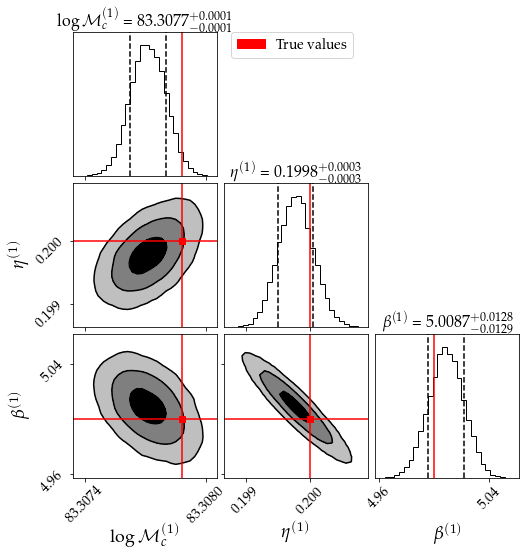

In [21]:
labels = [r'$\log\mathcal{M}^{(1)}_c$', r'$\eta^{(1)}$', r'$\beta^{(1)}$']
truths=[logMchirp_true,eta_true,beta_true]

range_values = [1.0,1.0,1.0]

fig = corner.corner(org_samp, bins=30,labels=labels, 
                    truths=truths, range = range_values,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()

In [22]:
#import pickle

#pickle.dump( org_samp, open( "inacc_rem_N15000.p", "wb" ) )
#org_samp_inacc_rem_N15000 = pickle.load( open( "inacc_rem_N15000.p", "rb" ) )

### Bias from the Fisher formalism

In [23]:
lnMc_delta = 1e-8
eta_delta = 1e-5
beta_delta = 1e-6

In [24]:
"""
Derivatives of reference signal.
"""

# Derivative wrt Mc.

pars_p = [pars[0] + lnMc_delta,pars[1],pars[2]]
pars_m = [pars[0] - lnMc_delta,pars[1],pars[2]]
d_dlnMc_ref = (htilde(freq,Deff,pars_p,tref,phiref,tune_app)
           -htilde(freq,Deff,pars_m,tref,phiref,tune_app))/(2*lnMc_delta)

# Derivative wrt eta.

pars_p = [pars[0],pars[1] + eta_delta,pars[2]]
pars_m = [pars[0],pars[1] - eta_delta,pars[2]]
d_deta_ref = (htilde(freq,Deff,pars_p,tref,phiref,tune_app)
          -htilde(freq,Deff,pars_m,tref,phiref,tune_app))/(2*eta_delta)

# Derivative wrt beta

pars_p = [pars[0],pars[1],pars[2]+ beta_delta]
pars_m = [pars[0],pars[1],pars[2]- beta_delta]
d_dbeta_ref = (htilde(freq,Deff,pars_p,tref,phiref,tune_app)
           -htilde(freq,Deff,pars_m,tref,phiref,tune_app))/(2*beta_delta)

In [25]:
"""
Derivatives of overlapping signal #1.
"""

# Derivative wrt Mc.

pars_p = [pars_ov1[0] + lnMc_delta,pars_ov1[1],pars_ov1[2]]
pars_m = [pars_ov1[0] - lnMc_delta,pars_ov1[1],pars_ov1[2]]
d_dlnMc_ov1 = (htilde(freq,Deff_ov1,pars_p,tov1,phiov1,tune_app)
           -htilde(freq,Deff_ov1,pars_m,tov1,phiov1,tune_app))/(2*lnMc_delta)

# Derivative wrt eta.

pars_p = [pars_ov1[0],pars_ov1[1] + eta_delta,pars_ov1[2]]
pars_m = [pars_ov1[0],pars_ov1[1] - eta_delta,pars_ov1[2]]
d_deta_ov1 = (htilde(freq,Deff_ov1,pars_p,tov1,phiov1,tune_app)
          -htilde(freq,Deff_ov1,pars_m,tov1,phiov1,tune_app))/(2*eta_delta)

# Derivative wrt beta

pars_p = [pars_ov1[0],pars_ov1[1],pars_ov1[2]+ beta_delta]
pars_m = [pars_ov1[0],pars_ov1[1],pars_ov1[2]- beta_delta]
d_dbeta_ov1 = (htilde(freq,Deff_ov1,pars_p,tov1,phiov1,tune_app)
           -htilde(freq,Deff_ov1,pars_m,tov1,phiov1,tune_app))/(2*beta_delta)

In [26]:
"""
Derivatives of overlapping signal #2.
"""

# Derivative wrt Mc.

pars_p = [pars_ov2[0] + lnMc_delta,pars_ov2[1],pars_ov2[2]]
pars_m = [pars_ov2[0] - lnMc_delta,pars_ov2[1],pars_ov2[2]]
d_dlnMc_ov2 = (htilde(freq,Deff_ov2,pars_p,tov2,phiov2,tune_app)
           -htilde(freq,Deff_ov2,pars_m,tov2,phiov2,tune_app))/(2*lnMc_delta)

# Derivative wrt eta.

pars_p = [pars_ov2[0],pars_ov2[1] + eta_delta,pars_ov2[2]]
pars_m = [pars_ov2[0],pars_ov2[1] - eta_delta,pars_ov2[2]]
d_deta_ov2 = (htilde(freq,Deff_ov2,pars_p,tov2,phiov2,tune_app)
          -htilde(freq,Deff_ov2,pars_m,tov2,phiov2,tune_app))/(2*eta_delta)

# Derivative wrt beta

pars_p = [pars_ov2[0],pars_ov2[1],pars_ov2[2]+ beta_delta]
pars_m = [pars_ov2[0],pars_ov2[1],pars_ov2[2]- beta_delta]
d_dbeta_ov2 = (htilde(freq,Deff_ov2,pars_p,tov2,phiov2,tune_app)
           -htilde(freq,Deff_ov2,pars_m,tov2,phiov2,tune_app))/(2*beta_delta)

In [27]:
"""
Find the Fisher matrix with your approximate waveforms, as this is the
one which is input in the MCMC and is thus the known waveform.
"""

Ntot = 3

diff_vec =[
           # Reference signal
           d_dlnMc_ref, d_deta_ref, d_dbeta_ref,
           # Overlapping source #1
            d_dlnMc_ov1, d_deta_ov1, d_dbeta_ov1,
            # Overlapping source #2
            d_dlnMc_ov2, d_deta_ov2, d_dbeta_ov2
            ]

fish_mix = np.eye(3*Ntot)
for i in range(0,3*Ntot):
    for j in range(0,3*Ntot):
        fish_mix[i,j] = inner_prod_FD(diff_vec[i],diff_vec[j],PSD,delta_f)

In [28]:
# Does the Fisher matrix approximate well (within a few digits) the MCMC widths? 
# If not, then there is a problem.

print('FM width predictions:',np.sqrt(np.diag(np.linalg.inv(fish_mix))))
print('MC width predictions:',  [np.round(np.sqrt(np.var(flat_samples[:,:,i])),17) 
                                 for i in range(0,3*Ntot)])

FM width predictions: [8.32849881e-05 2.67425892e-04 1.24729693e-02 2.34493853e-04
 1.02248744e-03 5.86169577e-02 2.75239857e-05 4.37101514e-06
 5.27581228e-04]
MC width predictions: [8.726170901626e-05, 0.00027833737097144, 0.01292742046057289, 0.00026969957078978, 0.00118419803819979, 0.06775738206468901, 2.757036212548e-05, 4.34861500749e-06, 0.00052385412323632]


In [29]:
# Inverse of the full fisher matrix

print('condition number full FM: ',np.linalg.cond(fish_mix))
FM_inv = np.linalg.inv(fish_mix)

# bias vector 

b = [inner_prod_FD(i,deltah,PSD,delta_f) for i in diff_vec]

# Inference biases

biases = np.matmul(FM_inv,b)

condition number full FM:  9049113501.787498


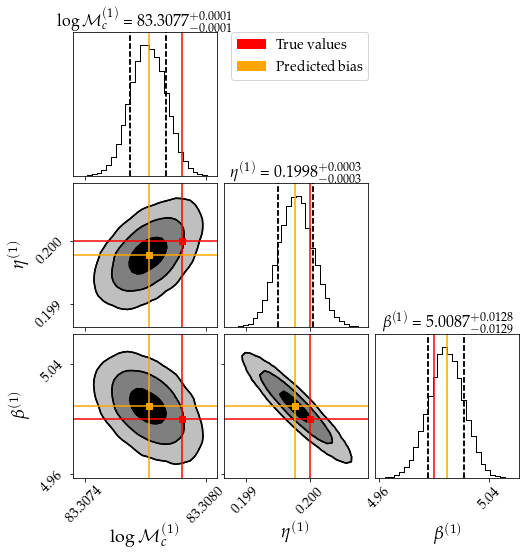

In [30]:
truths_bias =[logMchirp_true + biases[0], eta_true + biases[1 ], beta_true + biases[2]]

fig = corner.corner(org_samp, bins=30,labels=labels, 
                    truths=truths, range = range_values,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)
fig = corner.corner(org_samp, bins=30,labels=labels, 
                    truths=truths_bias, range = range_values,
                    truth_color='orange', 
                    color='black',**CORNER_KWARGS, fig=fig)

red_patch = mpatches.Patch(color='red', label='True values')
orange_patch = mpatches.Patch(color='orange', label='Predicted bias')
plt.legend(handles=[red_patch,orange_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
#plt.savefig('inacc_rem_bias.pdf')
plt.show()

In [31]:
np.abs(biases[0]/np.sqrt(FM_inv[0][0]))

1.981071146476155

In [32]:
np.abs(biases[1]/np.sqrt(FM_inv[1][1]))

0.8441376895843201

In [33]:
np.abs(biases[2]/np.sqrt(FM_inv[2][2]))

0.7404054567104373

### Few explorations

We add in a few more signals to see when all three parameters of the reference signal are significantly biases.

In [34]:
np.random.seed(35958)

# Number of sources to add to analysis above.

N_added = 20
diff_vec_expl  = diff_vec
deltah = deltah1 + deltah2

SNR_list = []
# deltah_list = [deltah]
# diff_vec_list = [diff_vec_expl]

while len(SNR_list) < N_added:

    """
    Extra overlapping signal
    """

    # Find a resonable distance for the signal 

    Deff_extra = np.random.uniform(1,10)*10**3 *Mpc
    logDeff_extra = np.log(Deff_extra)

    beta_extra = np.random.uniform(0.001,9.4)
    eta_extra = np.random.uniform(0.001,0.25)
    mtot_extra = 3*1e6 #in solar masses
    Mchirp_extra = mtot_extra*(eta_extra)**(3/5)
    Mchirp_extra =Mchirp_extra* M_sun
    logMchirp_extra = np.log(Mchirp_extra)

    pars_extra = [logMchirp_extra,eta_extra,beta_extra] # array of parameters to sample through

    # Fix these two impostors, assume they are known perfectly.

    t_extra =T_chirp(fmin,Mchirp_extra,eta_extra)
    phi_extra =0.0
    
    SNR_extra = np.sqrt(inner_prod_FD(htilde(freq,Deff_extra,pars_extra,t_extra,phi_extra,tune_true),
                      htilde(freq,Deff_extra,pars_extra,t_extra,phi_extra,tune_true) ,
                      PSD,delta_f))
    
    if SNR_extra < 1500:
        continue
        
    else:
        
        SNR_list.append(SNR_list)

        """
        Derivatives of extra overlapping signal
        """

        # Derivative wrt Mc.

        pars_p = [pars_extra[0] + lnMc_delta,pars_extra[1],pars_extra[2]]
        pars_m = [pars_extra[0] - lnMc_delta,pars_extra[1],pars_extra[2]]
        d_dlnMc_extra = (htilde(freq,Deff_extra,pars_p,t_extra,phi_extra,tune_app)
                   -htilde(freq,Deff_extra,pars_m,t_extra,phi_extra,tune_app))/(2*lnMc_delta)
        diff_vec_expl.append(d_dlnMc_extra)

        # Derivative wrt eta.

        pars_p = [pars_extra[0],pars_extra[1] + eta_delta,pars_extra[2]]
        pars_m = [pars_extra[0],pars_extra[1] - eta_delta,pars_extra[2]]
        d_deta_extra = (htilde(freq,Deff_extra,pars_p,t_extra,phi_extra,tune_app)
                  -htilde(freq,Deff_extra,pars_m,t_extra,phi_extra,tune_app))/(2*eta_delta)
        diff_vec_expl.append(d_deta_extra)

        # Derivative wrt beta

        pars_p = [pars_extra[0],pars_extra[1],pars_extra[2]+ beta_delta]
        pars_m = [pars_extra[0],pars_extra[1],pars_extra[2]- beta_delta]
        d_dbeta_extra = (htilde(freq,Deff_extra,pars_p,t_extra,phi_extra,tune_app)
                   -htilde(freq,Deff_extra,pars_m,t_extra,phi_extra,tune_app))/(2*beta_delta)
        diff_vec_expl.append(d_dbeta_extra)

        deltah_extra = (htilde(freq,Deff_extra,pars_extra,t_extra,phi_extra,tune_true) 
                        - htilde(freq,Deff_extra,pars_extra,t_extra,phi_extra,tune_app))
        
        # Save into lists
        deltah+=deltah_extra

Calculate the Fisher matrix taking into account the extra signals.

In [35]:
Ntot_expl = Ntot + N_added

fish_mix_expl = np.eye(3*Ntot_expl)
for i in range(0,3*Ntot_expl):
    for j in range(0,3*Ntot_expl):
        fish_mix_expl[i,j] = inner_prod_FD(diff_vec_expl[i],diff_vec_expl[j],PSD,delta_f)
print(np.linalg.cond(fish_mix_expl))

2372542649982.052


Find the biases with the extra signals.

In [36]:
FM_inv_expl = np.linalg.inv(fish_mix_expl)

# bias vector 

b_expl = [inner_prod_FD(i,deltah,PSD,delta_f) for i in diff_vec_expl]

# Inference biases

biases_expl = np.matmul(FM_inv_expl,b_expl)

And here are the updated ratios

In [37]:
print('bias on lnMc:',np.abs(biases_expl[0]/np.sqrt(FM_inv_expl[0][0])))
print('bias on eta:', np.abs(biases_expl[1]/np.sqrt(FM_inv_expl[1][1])))
print('bias on beta:',np.abs(biases_expl[2]/np.sqrt(FM_inv_expl[2][2])))

bias on lnMc: 0.33498736823661845
bias on eta: 0.5095197247589308
bias on beta: 0.5092109338583672
